**Name:** Luong Nguyen  
**Student ID:** 1504210  
## Assignment Methods 6: Recommendation engines

In [2]:
# install surprise
!pip install scikit-surprise

    100% |████████████████████████████████| 3.3MB 9.4MB/s 
  Stored in directory: /root/.cache/pip/wheels/ec/c0/55/3a28eab06b53c220015063ebbdb81213cd3dcbb72c088251ec
Successfully built scikit-surprise


In [0]:
# import needed library
import pandas as pd
import numpy as np
from collections import defaultdict
from surprise import Reader
from surprise import KNNBasic
from surprise import Dataset
from surprise.model_selection import cross_validate

### Data preparation  
*(need to upload files to colab in order to rerun the code)*

In [11]:
anime = pd.read_csv('anime.csv')
anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [31]:
rating = pd.read_csv('rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [15]:
# merge 2 table to include the anime names
df = pd.merge(anime[['anime_id', 'name']], rating, on='anime_id', how='inner')
df.head()

,anime_id,name,user_id,rating
0,32281,Kimi no Na wa.,99,5
1,32281,Kimi no Na wa.,152,10
2,32281,Kimi no Na wa.,244,10
3,32281,Kimi no Na wa.,271,10
4,32281,Kimi no Na wa.,278,-1


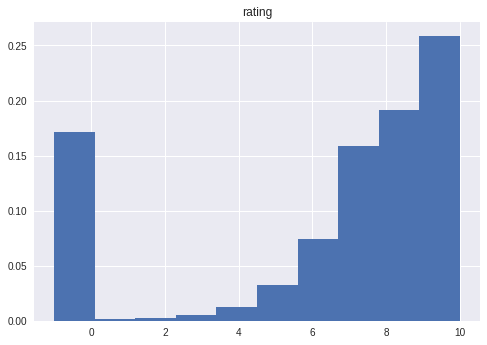

In [22]:
# ratings distribution
hist = df.hist(column='rating', density=True)

**Result when running Surprise with the original dataset**  
`Computing the msd similarity matrix...
Done computing similarity matrix.
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)`  
**We need to reduce the dimensinality of the dataset**

In [66]:
# reduce the dimensionality of the data set to avoid running into “memory error”

filter_animes = df['anime_id'].value_counts() > 2000 
filter_animes = filter_animes[filter_animes].index.tolist()

filter_users = df['user_id'].value_counts() > 1000
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['anime_id'].isin(filter_animes)) & (df['user_id'].isin(filter_users))]
print(f'The original data frame shape: {df.shape}')
print(f'The new data frame shape: {df_new.shape}')
print(f'The original number of animes: {len(df["anime_id"].unique())}')
print(f'The remained number of animes: {len(df_new["anime_id"].unique())}')
print(f'The original number of users: {len(df["user_id"].unique())}')
print(f'The remained number of users: {len(df_new["user_id"].unique())}')

The original data frame shape: (2402460, 4)
The new data frame shape: (13005, 4)
The original number of animes: 9377
The remained number of animes: 261
The original number of users: 22978
The remained number of users: 71


### Surprise

In [98]:
# Construct reader
reader = Reader(rating_scale=(-1, 10))

# Generate surprise Dataset
data = Dataset.load_from_df(df_new[['user_id', 'anime_id', 'rating']], reader)

# Set all data as training set
trainset = data.build_full_trainset()

# Build and train an algorithm.

sim_options = {
               'user_based': True  # compute  similarities between items
}

algo = KNNBasic(sim_options=sim_options)
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

# Example:output
print(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
[Prediction(uid=342, iid=11061, r_ui=6.6916570549788545, est=7.155180665493221, details={'actual_k': 32, 'was_impossible': False}), Prediction(uid=342, iid=199, r_ui=6.6916570549788545, est=5.492565763674466, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342, iid=164, r_ui=6.6916570549788545, est=5.309644205322093, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342, iid=7311, r_ui=6.6916570549788545, est=6.2833725123447515, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342, iid=2001, r_ui=6.6916570549788545, est=5.826374328922436, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342, iid=245, r_ui=6.6916570549788545, est=5.763569381759974, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342, iid=431, r_ui=6.6916570549788545, est=6.138804579331518, details={'actual_k': 40, 'was_impossible': False}), Prediction(uid=342

In [144]:

# This block copied from Surprise documentation at
# http://surprise.readthedocs.io/en/stable/FAQ.html#how-to-get-the-top-n-recommendations-for-each-user

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(predictions, n=5)

# Print the recommended animes for each user
for uid, user_ratings in top_n.items():
    print(f'User {uid}: {[df_new.loc[df_new.anime_id == aid].name.tolist()[0] for (aid, _) in user_ratings]} \n')

User 342: ['Rurouni Kenshin: Meiji Kenkaku Romantan', 'Yuu☆Yuu☆Hakusho', 'Hunter x Hunter (2011)', 'Baccano!', 'Dragon Ball Z'] 

User 1344: ['Suzumiya Haruhi no Shoushitsu', 'Usagi Drop', 'Kimi ni Todoke', 'Kanon (2006)', 'Yuu☆Yuu☆Hakusho'] 

User 1530: ['Code Geass: Hangyaku no Lelouch R2', 'Code Geass: Hangyaku no Lelouch', 'Mononoke Hime', 'Sen to Chihiro no Kamikakushi', 'Bakemonogatari'] 

User 2951: ['Hunter x Hunter (2011)', 'Fate/Zero 2nd Season', 'Fate/Zero', 'Yuu☆Yuu☆Hakusho', 'Kuroko no Basket 2nd Season'] 

User 3569: ['Code Geass: Hangyaku no Lelouch R2', 'Hunter x Hunter (2011)', 'Code Geass: Hangyaku no Lelouch', 'Ookami Kodomo no Ame to Yuki', 'Zetsuen no Tempest'] 

User 5310: ['Hunter x Hunter (2011)', 'Mononoke Hime', 'Ookami Kodomo no Ame to Yuki', 'Black Lagoon', 'Howl no Ugoku Shiro'] 

User 5705: ['Berserk', 'Digimon Adventure', 'Baccano!', 'Haikyuu!!', 'Yuu☆Yuu☆Hakusho'] 

User 5831: ['Hunter x Hunter (2011)', 'Durarara!!', 'Zetsuen no Tempest', 'Ookami Kodomo 

In [145]:
# Evaluate accuracy
cross_validate(algo, data, measures=['MAE', 'RMSE'], cv=3, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating MAE, RMSE of algorithm KNNBasic on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
MAE (testset)     1.6148  1.6140  1.6565  1.6284  0.0199  
RMSE (testset)    2.4484  2.4157  2.4702  2.4448  0.0224  
Fit time          0.01    0.01    0.01    0.01    0.00    
Test time         0.24    0.23    0.22    0.23    0.01    


{'fit_time': (0.009479999542236328, 0.010603904724121094, 0.01080775260925293),
 'test_mae': array([1.61475257, 1.61398365, 1.65653547]),
 'test_rmse': array([2.44838286, 2.41566344, 2.47024751]),
 'test_time': (0.23772954940795898, 0.23207736015319824, 0.22261834144592285)}